In [1]:
import os
import numpy as np
import torch
from transformers import BertTokenizer, BertTokenizerFast, BertForSequenceClassification, BertModel
import math
import torch.nn as nn
import os
import numpy as np
import re
# import matplotlib
import argparse
# matplotlib.use('Qt5Agg')
import matplotlib.pyplot as plt
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence
from torch import nn
import copy
import math
from tqdm.auto import tqdm,trange
from torch.nn import SyncBatchNorm
from torch.utils.data.dataloader import default_collate
from torch.nn.parallel import DistributedDataParallel
import torch.distributed as dist
from torch.utils.data.distributed import DistributedSampler
# from torch.utils.tensorboard import SummaryWriter
import datasets
import json
import evaluate
from datasets import load_dataset, load_from_disk
work_dir = "./"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [18]:
import os
from collections import defaultdict, Counter
import platform
if "Windows" in platform.system() or "windows" in platform.system():
    os.environ["http_proxy"] = "http://127.0.0.1:7890"
    os.environ["https_proxy"] = "http://127.0.0.1:7890"

In [2]:
dataset = load_dataset("cnn_dailymail", '3.0.0')
dataset

Using the latest cached version of the module from D:\ProgramData\huggingface\modules\datasets_modules\datasets\cnn_dailymail\1b3c71476f6d152c31c1730e83ccb08bcf23e348233f4fcc11e182248e6bf7de (last modified on Sat Mar 11 16:11:44 2023) since it couldn't be found locally at cnn_dailymail., or remotely on the Hugging Face Hub.
Found cached dataset cnn_dailymail (D:/ProgramData/huggingface/datasets/cnn_dailymail/3.0.0/3.0.0/1b3c71476f6d152c31c1730e83ccb08bcf23e348233f4fcc11e182248e6bf7de)


  0%|          | 0/3 [00:00<?, ?it/s]

DatasetDict({
    train: Dataset({
        features: ['article', 'highlights', 'id'],
        num_rows: 287113
    })
    validation: Dataset({
        features: ['article', 'highlights', 'id'],
        num_rows: 13368
    })
    test: Dataset({
        features: ['article', 'highlights', 'id'],
        num_rows: 11490
    })
})

In [3]:
from nltk.tokenize import sent_tokenize
sent_tokenize(dataset["train"][0]["article"])

["LONDON, England (Reuters) -- Harry Potter star Daniel Radcliffe gains access to a reported £20 million ($41.1 million) fortune as he turns 18 on Monday, but he insists the money won't cast a spell on him.",
 'Daniel Radcliffe as Harry Potter in "Harry Potter and the Order of the Phoenix" To the disappointment of gossip columnists around the world, the young actor says he has no plans to fritter his cash away on fast cars, drink and celebrity parties.',
 '"I don\'t plan to be one of those people who, as soon as they turn 18, suddenly buy themselves a massive sports car collection or something similar," he told an Australian interviewer earlier this month.',
 '"I don\'t think I\'ll be particularly extravagant.',
 '"The things I like buying are things that cost about 10 pounds -- books and CDs and DVDs."',
 'At 18, Radcliffe will be able to gamble in a casino, buy a drink in a pub or see the horror film "Hostel: Part II," currently six places below his number one movie on the UK box off

In [5]:
def get_rouge_prompt_article(example):
    from nltk.tokenize import sent_tokenize
    article_sents = sent_tokenize(example['article'])
    highlights_sents = sent_tokenize(example['highlights'])
    if len(highlights_sents) == 1:
        highlights_sents = sent_tokenize(example['highlights'].replace("\n", ". "))
    if len(highlights_sents) == 1:
        highlights_sents = sent_tokenize(example['highlights'].replace("  ", ". "))

    from rouge_score import rouge_scorer
    scorer = rouge_scorer.RougeScorer(['rouge2'], use_stemmer=True)
    flag = 0
    for i, article_sent in enumerate(article_sents):
        rouges = []
        for j, highlights_sent in enumerate(highlights_sents):
            score = scorer.score(highlights_sent, article_sent)["rouge2"].fmeasure
            rouges.append((j + 1, score))
        rouges = sorted(rouges, key=lambda x: x[1], reverse=True)
        if rouges[0][1] > 0:
            article_sents[i] = f'[{rouges[0][0]}] {article_sents[i]} [/{rouges[0][0]}]'
            flag = 1
    example['article'] = ' '.join(article_sents)
    example['flag'] = flag
    return example

In [ ]:
ds = dataset.map(get_rouge_prompt_article, num_proc=20)

In [29]:
ds2 = dataset.map(get_prompt_article, num_proc=20)

In [27]:
from nltk.tokenize import sent_tokenize
index = 5
highlights_sents = sent_tokenize(dataset["train"][index]["highlights"])
if len(highlights_sents) == 1:
    highlights_sents = sent_tokenize(dataset["train"][index]["highlights"].replace("\n", ". "))
if len(highlights_sents) == 1:
    highlights_sents = sent_tokenize(dataset["train"][index]["highlights"].replace("  ", ". "))
highlights_sents

["Parents beam with pride, can't stop from smiling from outpouring of support .",
 'Mom: "I was so happy I didn\'t know what to do"\nBurn center in U.S. has offered to provide treatment for reconstructive surgeries .',
 'Dad says, "Anything for Youssif"']

In [40]:
ds2["train"][index]["article"]

'BAGHDAD, Iraq (CNN) -- Dressed in a Superman shirt, 5-year-old Youssif held his sister\'s hand Friday, seemingly unaware that millions of people across the world have been touched by his story. Nearby, his parents talked about the new future and hope they have for their boy -- and the potential for recovery from his severe burns. Youssif holds his sister\'s hand Friday. He\'s wearing a facial mask often used to help burn victims. It\'s the best birthday present the Iraqi family could ever have imagined for their boy: Youssif turns 6 next Friday. [2] "I was so happy I didn\'t know what to do with myself," his mother, Zainab, told CNN, a broad smile across her face. [/2] [2] "I didn\'t think the reaction would be this big." [/2] [1] His father said he was on the roof of his house when CNN called him with the news about the outpouring of support for his son. [/1] "We just want to thank everyone who has come forward," he said. "We knew there was kindness out there." [1] Like his wife, he 

In [20]:
from rouge_score import rouge_scorer
scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)
scorer.score("Parents beam with pride, can't stop from smiling from outpouring of support .", 'His father said he was on the roof of his house when CNN called him with the news about the outpouring of support for his son.')

{'rouge1': Score(precision=0.15384615384615385, recall=0.3076923076923077, fmeasure=0.20512820512820515),
 'rouge2': Score(precision=0.08, recall=0.16666666666666666, fmeasure=0.10810810810810811),
 'rougeL': Score(precision=0.15384615384615385, recall=0.3076923076923077, fmeasure=0.20512820512820515)}

In [104]:
from transformers import AutoModelForSeq2SeqLM

model = AutoModelForSeq2SeqLM.from_pretrained("facebook/bart-large")

In [9]:
model.model.encoder

BartEncoder(
  (embed_tokens): Embedding(50265, 1024, padding_idx=1)
  (embed_positions): BartLearnedPositionalEmbedding(1026, 1024)
  (layers): ModuleList(
    (0): BartEncoderLayer(
      (self_attn): BartAttention(
        (k_proj): Linear(in_features=1024, out_features=1024, bias=True)
        (v_proj): Linear(in_features=1024, out_features=1024, bias=True)
        (q_proj): Linear(in_features=1024, out_features=1024, bias=True)
        (out_proj): Linear(in_features=1024, out_features=1024, bias=True)
      )
      (self_attn_layer_norm): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
      (activation_fn): GELUActivation()
      (fc1): Linear(in_features=1024, out_features=4096, bias=True)
      (fc2): Linear(in_features=4096, out_features=1024, bias=True)
      (final_layer_norm): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
    )
    (1): BartEncoderLayer(
      (self_attn): BartAttention(
        (k_proj): Linear(in_features=1024, out_features=1024, bias=True

In [23]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("facebook/bart-large")

In [13]:
output.encoder_last_hidden_state.shape

NameError: name 'output' is not defined

In [67]:
tokenizer.special_tokens_map

{'bos_token': '<s>',
 'eos_token': '</s>',
 'unk_token': '<unk>',
 'sep_token': '</s>',
 'pad_token': '<pad>',
 'cls_token': '<s>',
 'mask_token': '<mask>'}

In [85]:
tokenizer(['i love you .'], max_length=20, padding='max_length')

{'input_ids': [[0, 118, 657, 47, 479, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]], 'attention_mask': [[1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]}

In [78]:
(type(tokenizer(['i love you .']))

transformers.tokenization_utils_base.BatchEncoding

In [77]:
dict(tokenizer(['i love you .']))

{'input_ids': [0, 118, 657, 47, 479, 2], 'attention_mask': [1, 1, 1, 1, 1, 1]}

In [120]:
batch = tokenizer(['i love you', 'i am chinese? you are american! who am i. who are you'], return_tensors='pt', padding=True)
batch

{'input_ids': tensor([[    0,   118,   657,    47,     2,     1,     1,     1,     1,     1,
             1,     1,     1,     1,     1,     1,     1,     1,     1],
        [    0,   118,   524,  1855, 33965,   116,    47,    32, 38187,   260,
           328,    54,   524,   939,     4,    54,    32,    47,     2]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])}

In [252]:
index = 0
batch = tokenizer([dataset['train'][index]['article']], return_tensors='pt', padding=True)
label_batch = tokenizer([dataset['train'][index]['highlights']], return_tensors='pt', padding=True)

In [247]:
outputs = model(**batch)

In [253]:
label_outputs = model(**label_batch)

In [248]:
outputs.encoder_last_hidden_state

tensor([[[ 0.0010,  0.0416,  0.0414,  ...,  0.0017,  0.0055, -0.0012],
         [ 0.1966, -0.1000, -0.2184,  ..., -0.2350, -0.2222,  0.1250],
         [-0.2357,  0.2553,  0.1261,  ..., -0.0563,  0.0406,  0.2011],
         ...,
         [ 0.0681, -0.5526, -0.6510,  ...,  0.0201,  0.0405,  0.1527],
         [ 0.0023,  0.0141,  0.0062,  ...,  0.0052, -0.0063, -0.0039],
         [-0.0534,  0.4475, -0.0751,  ...,  0.1409,  0.0267, -0.1297]]],
       grad_fn=<NativeLayerNormBackward0>)

In [254]:

# def cluster_prompt(batch, outputs):
from sklearn.cluster import KMeans
from nltk.tokenize import sent_tokenize
encoder_last_hidden_state = outputs.encoder_last_hidden_state
articles = tokenizer.batch_decode(batch.input_ids, skip_special_tokens=True)
for article_index, article in enumerate(articles):
    sents = sent_tokenize(article)
    kmeans = KMeans(n_clusters=3)
    embeddings = []
    start_position = 1
    for sent in sents:
        # print(sent)
        sent_len = len(tokenizer(sent).input_ids) - 2
        embeddings.append(torch.mean(encoder_last_hidden_state[article_index, start_position: start_position + sent_len], dim=0))
        # print(tokenizer.decode(batch.input_ids[article_index, start_position: start_position + sent_len], skip_special_tokens=False))
        start_position += sent_len
    embeddings = torch.stack(embeddings)
    # print(embeddings.shape)
    np_emb = embeddings.cpu().detach().numpy()
    kmeans = kmeans.fit(np_emb)
    # km_labels = km.labels_
    # print(km_labels)
    for n_cluster_index in range(kmeans.n_clusters):
        distances = kmeans.transform(np_emb)[:, n_cluster_index]
        # print(len([closest_i for closest_i in np.argsort(distances) if kmeans.labels_[closest_i] == n_cluster_index]))
        # closest = [closest_i for closest_i in np.argsort(distances) if kmeans.labels_[closest_i] == n_cluster_index][:3]
        closest = np.argsort(distances)[:3]
        for center_sent_index in closest:
            sents[center_sent_index] = f'[{n_cluster_index + 1}] {sents[center_sent_index]} [/{n_cluster_index + 1}]'
    article = ' '.join(sents)
    articles[article_index] = article
    # return articles


In [256]:
label_encoder_last_hidden_state = label_outputs.encoder_last_hidden_state
highlights = tokenizer.batch_decode(label_batch.input_ids, skip_special_tokens=True)
for highlight_index, highlight in enumerate(highlights):
    sents = sent_tokenize(highlight)
    label_embeddings = []
    start_position = 1
    for sent in sents:
        # print(sent)
        sent_len = len(tokenizer(sent).input_ids) - 2
        label_embeddings.append(torch.mean(label_encoder_last_hidden_state[highlight_index, start_position: start_position + sent_len], dim=0))
        # print(tokenizer.decode(batch.input_ids[article_index, start_position: start_position + sent_len], skip_special_tokens=False))
        start_position += sent_len
    label_embeddings = torch.stack(label_embeddings)
    # print(embeddings.shape)
    label_np_emb = label_embeddings.cpu().detach().numpy()

In [ ]:
print(cluster_prompt(batch, outputs))


In [259]:
np_emb.shape, label_np_emb.shape

((24, 1024), (3, 1024))

In [263]:
np.concatenate((np_emb, label_np_emb), axis=0).shape

(27, 1024)

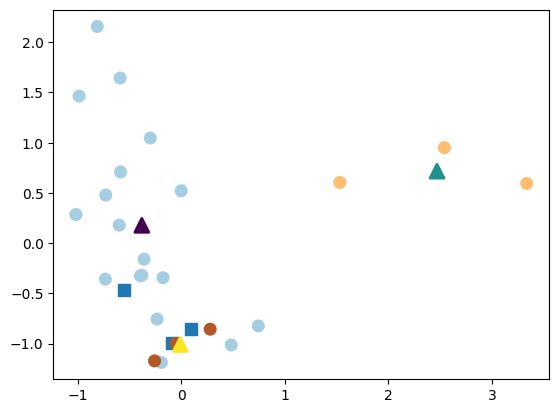

In [268]:
from sklearn.decomposition import PCA

pca = PCA(2)
pca.fit(np.concatenate((np_emb, label_np_emb), axis=0))
pc = pca.transform(np_emb)
pc1 = pc[:,0]
pc2 = pc[:,1]

label_pc = pca.transform(label_np_emb)
label_pc1 = label_pc[:,0]
label_pc2 = label_pc[:,1]
plt.scatter(label_pc1, label_pc2,  s=70, marker=',')

center_pca = pca.transform(kmeans.cluster_centers_)


plt.scatter(pc1, pc2, c=kmeans.labels_, s=70, cmap='Paired')
plt.scatter(center_pca[:, 0],
            center_pca[:, 1],
            marker='^', s=100, linewidth=2,
            c=[0, 1, 2])

In [44]:
kmeans.labels_

array([0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 2,
       2, 0])

In [41]:
kmeans.transform(embeddings)[:]

array([[1.8875147, 2.4368193, 3.8458095],
       [2.1125414, 2.376165 , 4.0181   ],
       [2.1922202, 2.6576107, 4.4775267],
       [2.472419 , 3.3321526, 4.3292017],
       [2.8952596, 2.6884267, 4.414578 ],
       [2.409635 , 1.8145608, 4.0747232],
       [2.671709 , 3.228286 , 4.4727883],
       [2.8409727, 3.4722009, 4.3299847],
       [2.345668 , 3.1948397, 4.1206346],
       [2.9424274, 3.796294 , 4.6924977],
       [2.1717768, 2.5577514, 4.1509323],
       [2.2988849, 2.8845935, 4.430112 ],
       [2.1677403, 2.908003 , 4.2682676],
       [2.7006412, 3.3809853, 4.626253 ],
       [2.7916174, 2.1393073, 4.3147025],
       [3.3273437, 2.757976 , 4.041887 ],
       [3.529254 , 3.0727253, 4.471306 ],
       [2.813436 , 1.89423  , 3.9298942],
       [2.9368515, 2.0055351, 4.2760143],
       [2.933595 , 2.1511993, 4.4322977],
       [2.12886  , 2.6574483, 4.265719 ],
       [3.8005393, 3.8818672, 2.0329814],
       [4.235503 , 4.2666497, 2.0329814],
       [2.9589565, 3.3033164, 3.20

In [133]:
ds2["train"][0]["article"]

'[1] LONDON, England (Reuters) -- Harry Potter star Daniel Radcliffe gains access to a reported £20 million ($41.1 million) fortune as he turns 18 on Monday, but he insists the money won\'t cast a spell on him. [/1] [2] Daniel Radcliffe as Harry Potter in "Harry Potter and the Order of the Phoenix" To the disappointment of gossip columnists around the world, the young actor says he has no plans to fritter his cash away on fast cars, drink and celebrity parties. [/2] [2] "I don\'t plan to be one of those people who, as soon as they turn 18, suddenly buy themselves a massive sports car collection or something similar," he told an Australian interviewer earlier this month. [/2] "I don\'t think I\'ll be particularly extravagant. "The things I like buying are things that cost about 10 pounds -- books and CDs and DVDs." At 18, Radcliffe will be able to gamble in a casino, buy a drink in a pub or see the horror film "Hostel: Part II," currently six places below his number one movie on the UK 

In [125]:
import numpy as np
from sklearn.cluster import KMeans

# 生成随机数据
X = np.random.rand(100, 2)

# 假设有3个聚类中心
kmeans = KMeans(n_clusters=3)

# 训练模型
kmeans.fit(X)

# 对于每个聚类中心，找到距离它最近的三个数据点
closest_points = []
for i in range(kmeans.n_clusters):
    distances = kmeans.transform(X)[:, i]
    closest = np.argsort(distances)[:3]
    closest_points.append(closest)

# 打印结果
for i, closest in enumerate(closest_points):
    print(f"Cluster {i} closest points: {closest}")

Cluster 0 closest points: [ 7 59 94]
Cluster 1 closest points: [75 35 54]
Cluster 2 closest points: [44 97 36]


In [238]:
tokenizer(" •        ' Here’s Johnny' scene – 28.").input_ids

[0,
 1347,
 1437,
 1437,
 1437,
 1437,
 1437,
 1437,
 1437,
 128,
 1398,
 17,
 27,
 29,
 8781,
 108,
 1310,
 126,
 971,
 4,
 2]

In [237]:
" •        ' Here’s Johnny' scene – 28."

" •        ' Here’s Johnny' scene – 28."

In [235]:
tokenizer.convert_ids_to_tokens([0, 1347, 50144, 50188, 50141, 108, 1398, 17, 27, 29, 8781, 108, 1310, 126, 971, 4, 2])

['<s>',
 'ĠâĢ¢',
 'ÂłÂłÂłÂł',
 'ÂłÂłÂł',
 'Âł',
 "'",
 'ĠHere',
 'âĢ',
 'Ļ',
 's',
 'ĠJohnny',
 "'",
 'Ġscene',
 'ĠâĢĵ',
 'Ġ28',
 '.',
 '</s>']

In [236]:
tokenizer.convert_ids_to_tokens([ 1347, 50147,   128,  1398,    17,    27,    29,  8781,   108,  1310,
          126,   971,     4,   733,   207])

['ĠâĢ¢',
 'ÂłÂłÂłÂłÂłÂłÂłÂł',
 "Ġ'",
 'ĠHere',
 'âĢ',
 'Ļ',
 's',
 'ĠJohnny',
 "'",
 'Ġscene',
 'ĠâĢĵ',
 'Ġ28',
 '.',
 'Ġ21',
 '%']

In [239]:
print(tokenizer.decode([0, 870, 479, 9153, 1509, 3624, 119, 5229, 479, 29731, 7976, 14849, 1691, 35, 479, 15007, 35, 706, 12936, 6, 508, 494, 1014, 479, 1721, 479, 121, 44964, 35, 479, 12112, 35, 15007, 12936, 6, 508, 494, 1014, 479, 83, 985, 56, 7, 492, 69, 80, 12, 180, 12, 279, 979, 5, 13301, 9, 301, 77, 37, 2294, 9589, 71, 12241, 7520, 27730, 5010, 19109, 29, 13, 29842, 71, 41, 9121, 1447, 7, 1004, 62, 4, 9153, 1547, 6, 974, 6, 9741, 79, 21, 164, 7, 2217, 69, 979, 6, 4471, 6, 77, 37, 7793, 23, 49, 184, 11, 30709, 7254, 6, 4536, 21676, 5641, 6867, 4, 4471, 554, 23600, 26435, 71, 4441, 5, 19109, 29, 8200, 5, 6305, 9, 62, 7, 379, 14407, 12, 5985, 9, 27730, 4, 635, 6, 1135, 2269, 9391, 31740, 6, 16443, 1447, 7, 1004, 62, 8, 71, 291, 728, 2135, 1547, 21, 1654, 7, 1149, 11, 77, 69, 979, 1224, 2440, 4, 128, 6310, 571, 15876, 108, 4832, 9153, 1547, 26, 79, 21, 1654, 7, 185, 814, 7, 1871, 69, 979, 4471, 71, 51, 58, 314, 2445, 55, 87, 291, 728, 13, 41, 9121, 479, 264, 5590, 16443, 456, 53, 1449, 79, 21, 174, 14, 5, 9121, 74, 28, 89, 11, 277, 457, 41, 1946, 4, 128, 38, 56, 7, 4627, 11, 39, 6085, 7, 1871, 39, 301, 6, 128, 26, 2135, 1547, 6, 54, 355, 14, 79, 21, 128, 4940, 32759, 108, 19, 5, 9121, 544, 25, 10, 898, 9, 5, 17702, 15, 395, 4, 128, 318, 127, 979, 56, 962, 6, 38, 218, 108, 326, 216, 99, 38, 74, 33, 626, 4, 128, 20, 80, 12, 180, 12, 279, 56, 57, 2494, 2384, 23, 39, 8853, 108, 579, 790, 11, 30709, 7254, 77, 37, 32305, 5, 19109, 29, 71, 2609, 106, 11, 69, 15811, 150, 39, 985, 21, 66, 9, 5, 929, 4, 6746, 34115, 2135, 1547, 2269, 9315, 31740, 77, 79, 1835, 7, 465, 4471, 1826, 5, 29635, 9, 11568, 12444, 405, 179, 3635, 354, 4, 128, 404, 9, 10, 7207, 37, 95, 439, 269, 18100, 6, 37, 56, 117, 301, 11, 123, 6, 128, 79, 26, 4, 91, 21, 164, 2440, 98, 52, 7843, 11469, 41, 9121, 1359, 409, 4, 128, 1308, 2138, 7843, 11469, 5, 9121, 8, 51, 26, 24, 21, 15, 63, 169, 6, 128, 26, 2135, 1547, 6, 54, 34, 277, 979, 8, 80, 7172, 4, 128, 1892, 4471, 300, 10, 319, 3007, 98, 52, 7843, 11469, 291, 728, 423, 8, 51, 26, 24, 74, 28, 259, 11, 457, 41, 1946, 4, 128, 128, 37527, 108, 4832, 2135, 1547, 6, 450, 314, 19, 4471, 6, 26, 69, 979, 56, 802, 5, 27730, 19109, 29, 58, 29842, 479, 2135, 1547, 108, 579, 2138, 2094, 3409, 8110, 1276, 7, 6187, 39, 19419, 2761, 8, 69, 979, 7, 289, 3796, 154, 7450, 5361, 2392, 1003, 4, 128, 166, 300, 123, 11, 5, 512, 8, 37, 21, 164, 11, 8, 66, 9, 16253, 6, 128, 26, 2135, 1547, 4, 128, 1892, 37, 2294, 9589, 111, 38, 56, 7, 4627, 11, 39, 6085, 7, 1871, 39, 301, 4, 128, 660, 953, 9, 1156, 8387, 922, 2389, 1841, 1565, 26, 10, 6379, 1263, 1155, 21, 14987, 77, 2135, 1547, 2269, 9315, 31740, 8, 21, 15, 768, 7, 1338, 5, 1310, 624, 5, 389, 2289, 1002, 86, 278, 13, 1519, 9, 14, 2574, 4, 91, 26, 2135, 1547, 108, 579, 979, 21, 13316, 8, 9589, 23, 5, 86, 9, 5, 486, 6, 61, 21, 13959, 25, 10, 128, 4120, 2272, 80, 108, 2156, 111, 5056, 7, 41, 1160, 14, 16, 1473, 53, 45, 301, 12, 10940, 4, 520, 5, 284, 373, 10, 200, 86, 6, 5, 5364, 21, 3978, 51, 74, 28, 1428, 5, 16290, 7, 1098, 1235, 6, 8, 5, 9121, 15, 63, 169, 7, 5, 790, 21, 373, 160, 4, 128, 1806, 531, 2145, 14, 31740, 16, 1887, 7, 492, 301, 12, 25836, 4490, 1484, 3887, 4, 152, 1160, 21, 12461, 6443, 149, 10, 10675, 5154, 486, 5516, 609, 25, 45, 301, 12, 10940, 6, 128, 5, 9121, 544, 26, 4, 4471, 6, 54, 21, 576, 1923, 1416, 8, 1682, 11, 1098, 4427, 6, 16, 122, 7979, 23, 184, 19, 39, 985, 4, 125, 2135, 1547, 26, 35, 128, 318, 402, 101, 42, 1102, 456, 38, 1979, 108, 326, 1028, 41, 9121, 4, 128, 1437, 2], skip_special_tokens=True))

 By. Kerry Mcdermott. PUBLISHED:. 06: 24 EST, 13 March 2013. |. UPDATED:. 08: 06 EST, 13 March 2013. A mother had to give her two-year-old son the kiss of life when he stopped breathing after mistaking nicotine replacement mints for sweets after an ambulance failed to turn up. Kerry Brown, 27, feared she was going to lose her son, Max, when he collapsed at their home in Huntingdon, Cambridgeshire. Max started vomiting violently after eating the mints containing the equivalent of up to 15 cigarettes-worth of nicotine. However, despite dialling 999, paramedics failed to turn up and after 20 minutes Ms Brown was forced to step in when her son turned blue.'Disgusted' : Kerry Brown said she was forced to take action to save her son Max after they were left waiting more than 20 minutes for an ambulance. She contacted paramedics again but claims she was told that the ambulance would be there in another half an hour.'I had to blow in his mouth to save his life,'said Ms Brown, who added that sh

In [286]:
tokenizer.decode([0])

'<s>'

In [290]:
tokenizer.padding_token

{'bos_token': '<s>',
 'eos_token': '</s>',
 'unk_token': '<unk>',
 'sep_token': '</s>',
 'pad_token': '<pad>',
 'cls_token': '<s>',
 'mask_token': '<mask>'}

In [149]:
tokenizer(' Rights group Human Rights Watch welcomed the development. "')

{'input_ids': [0, 3941, 333, 3861, 3941, 3075, 5340, 5, 709, 4, 22, 2], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}

In [151]:
torch.mean(torch.tensor([[1., 2.], [3., 4.]]), dim=0).cpu().numpy().tolist()

AttributeError: 'Tensor' object has no attribute 'to_list'

In [273]:
substring = "\xa0"
# filtered_dataset = dataset.filter(lambda example: substring in example['article'])
filtered_dataset = dataset.filter(lambda example: substring in example['highlights'])
print(filtered_dataset['train'][0]['id'])
print('-' * 10)
print(filtered_dataset['train'][0]['article'])
print('-' * 10)
print(filtered_dataset['train'][0]['highlights'])
filtered_dataset['train'][0]['highlights']

1f4f11f6731f5338f3bf16ed3ec701716fade2ff
----------
Los Angeles (CNN) -- Jon Voight calls fellow actors Javier Bardem and Penelope Cruz "obviously ignorant" and warns a "poison letter" they signed "could incite anti-Semitism all over the world." Voight wrote in an opinion column published by the Hollywood Reporter on Sunday that Bardem and Cruz "should hang your heads in shame" and "ask forgiveness from the suffering people in Israel." Bardem and Cruz, who are married, co-signed a letter last week attacking Israel's treatment of Gaza. The actors were immediately attacked for their words, prompting both to issue statements saying they were just making pleas for peace. Celebs step into Israel-Gaza PR minefield . "I am now being labeled by some as anti-Semitic, as is my wife -- which is the antithesis of who we are as human beings," Bardem said in his follow-up statement.Â "We detest anti-Semitism as much as we detest the horrible and painful consequences of war." Cruz, who said she was "

'Jon Voight writes he\'s "more than angry" about Javier Bardem, Penelope Cruz .\nVoight wrote an opinion column for the Hollywood Reporter reacting to their letter .\nBardem and Cruz "should hang your heads in shame," Voight says .\nÂ\xa0"We detest anti-Semitism," Bardem says in a follow up to his Israel-Gaza letter .'

In [272]:
filtered_dataset

DatasetDict({
    train: Dataset({
        features: ['article', 'highlights', 'id'],
        num_rows: 16969
    })
    validation: Dataset({
        features: ['article', 'highlights', 'id'],
        num_rows: 2857
    })
    test: Dataset({
        features: ['article', 'highlights', 'id'],
        num_rows: 2231
    })
})

In [ ]:
'(CNN) -- Calls by Vice President Joe Biden and Secretary Hillary Clinton to "unite the world in the isolation of and dealing with the Iranians," in response to an alleged Iranian plot to kill Saudi Arabia\'s Ambassador in Washington, reflect a hubristic misapprehension of reality. The Obama Administration mistakenly believes it can exploit the accusations for strategic advantage. In fact, they are likely to play to Iran\'s advantage, not America\'s. The U.S. foreign policy community profoundly misunderstands the Islamic Republic\'s national security strategy. The Islamic Republic seeks to defend itself not primarily by conventional military power, in which it is deficient, but by forging ties to proxy allies around the region-actors with the ability to affect on-the-ground outcomes in key regional settings who are inclined to cooperate with Tehran. In some cases, these actors are discrete political movements, often with paramilitary capabilities, for example, Hezbollah in Lebanon and Shia political parties-cum-militias in Iraq. In other situations, Tehran sees public opinion as its chief ally. By contrasting some regimes\' cooperation with the United States and Israel with its own posture of "resistance" to American and Israeli ambitions to regional hegemony, Tehran cultivates "soft power" across the Middle East. Iran conceives its strategy, especially in a period of relative decline in America\'s standing, as one that constrains unfriendly regimes in the short term and undermines them in the longer term. Over the last decade, it has helped the Islamic Republic reap significant political and strategic gains in important theaters across the Middle East-Iraq, Lebanon, the Palestinian territories. With the advent of the Arab awakening at the end of last year, Iranian decision-makers are confident that some Arab states\' shift toward governments more reflective of their peoples\' attitudes and concerns-and, hence, more inclined to pursue more independent foreign policies vis-Ã\xa0-vis the United States and Israel-will work to Iran\'s advantage. Iranian policymakers correctly calculated that virtually any successor to Saddam Hussein \'s regime in Iraq would be a net positive for Iranian interests. Now, they calculate that a successor to the Mubarak regime in Egypt is bound to be less enthusiastic about strategic cooperation with the United States and Israel and more receptive to Iran\'s message of resistance. Iran\'s strategy toward Saudi Arabia runs very much along these lines. Tehran\'s approach is to highlight Saudi collusion with Washington and (at least indirectly) with Israel on important regional issues, thereby attracting support from ordinary Saudis-not just Saudi Shia but also Sunnis who dislike their government\'s pro-American stance. In the short term, Iran seeks to constrain the Saudi government from cooperating in military strikes or other coercive actions against it by making this an unpopular prospect for much of the Saudi population. In the longer term, Iran is working to transform the regional balance of power from one in which the United States, the Saudis, and other American allies dominate to one in which American, Israeli, and Saudi influence is marginalized by the diplomatic realignment of Lebanon, the Palestinian territories, Turkey, post-Saddam Iraq, and now Egypt. The Saudi leadership tries to push back by portraying Iran as an "alien", Shia/Persian element in its environment. At times, this helps the Kingdom hold the line against the Islamic Republic\'s soft power offensive. But the long-term trend is toward rising Iranian influence. In this context, the notion of an Iranian government plot to assassinate the Saudi Ambassador to the United States simply has no logic. History also suggests we treat the Obama Administration\'s claims of Iranian government complicity with deep skepticism. For eight years, during 1980-1988, the fledgling Islamic Republic had to defend itself against a war of aggression launched by Saddam Hussein -- a war of aggression financed primarily by Saudi Arabia. Nearly 300,000 Iranians were killed in that war. But, during the entire conflict, the Iranian government never targeted a single Saudi anywhere in the world. This is not because the Islamic Republic loves the Kingdom of Saudi Arabia. It is because Iran\'s national security strategy ultimately depends on appealing to the Saudi public not to support attacks against Iran, by harnessing popular anger over Israeli actions and U.S. overreach in the war on terror. Killing a Saudi Ambassador would have exactly the opposite effect. Whatever Mansour Ababsiar and his cousin may have talked about, it is wholly implausible that the Iranian leadership decided that this was a smart thing to do. The Obama Administration\'s calls for more concerted action against Iran will ultimately backfire-because they will be seen in most of the Muslim world (outside Saudi Arabia and Gulf Arab monarchies closely linked to Saudi Arabia) as the United States yet again leveling dubious life-and-death charges as the pretext to contain or even eliminate another Muslim power. President Obama, his advisers, and all Americans need to ask themselves if this is really the time to bring the United States even closer to another Middle East war fought in blind defiance of the region\'s strategic realities. The opinions expressed in this commentary are solely those of Flynt Leverett and Hillary Mann Leverett.',
 'Flynt Leverett and Hillary Mann Leveret say Joe Biden and Hillary Clinton reflect a hubristic version of reality .\nThey also say U.S. foreign policy misunderstands the Islamic Republic\'s national security strategy .\nAnd that Saudi leadership is trying to push back by portraying Iran as an "alien", Shia/Persian element in its environment .\nThe Obama Administration\'s "calls for more concerted action against Iran will ultimately backfire"')

In [223]:
import unicodedata
s = filtered_dataset['train'][0]['article']
unicodedata.normalize('NFKC', s)

"By . Victoria Woollaston . What makes a film scary divides opinion - some people prefer tense psychological thrillers, while others want jumpy, edge-of-their seat emotional rollercoasters. In an attempt to put an end to this debate, Japanese-owned website Rakuten's Play.com asked people to vote on which horror films they considered to be the most terrifying. They then wired a selection of viewers up to heart monitors and tracked changes in their pulse to determine exactly which of the top movie moments got their hearts racing the most. The winner was the iconic 'Here's Johnny' scene from 1980 film The Shining, which made pulses race and jump by 28.21 per cent. The Shining, and its 'Here's Johnny' scene made pulses race the most, making them jump by 28.21 per cent . A Nightmare on Elm Street had the . greatest physical effect overall, increasing audience members’ heart rates by . 26.8 per cent on average, but the poll results combined with the individual scariest scene scores put The S

In [233]:
unicodedata.normalize('NFKC', '\u30001')

' 1'

In [213]:
bad_dataset = dataset.filter(lambda example: len(sent_tokenize(example['article'])) <= 3)
bad_dataset

  0%|          | 0/288 [00:00<?, ?ba/s]

  0%|          | 0/14 [00:00<?, ?ba/s]

  0%|          | 0/12 [00:00<?, ?ba/s]

DatasetDict({
    train: Dataset({
        features: ['article', 'highlights', 'id'],
        num_rows: 74
    })
    validation: Dataset({
        features: ['article', 'highlights', 'id'],
        num_rows: 5
    })
    test: Dataset({
        features: ['article', 'highlights', 'id'],
        num_rows: 5
    })
})

In [161]:
bad_ids = {"0405e4119ac6c1eb83bff8dcc69953a8691d737b"}
removed_dataset = dataset.filter(lambda example: example['id'] not in bad_ids)
removed_dataset

DatasetDict({
    train: Dataset({
        features: ['article', 'highlights', 'id'],
        num_rows: 287112
    })
    validation: Dataset({
        features: ['article', 'highlights', 'id'],
        num_rows: 13368
    })
    test: Dataset({
        features: ['article', 'highlights', 'id'],
        num_rows: 11490
    })
})

In [158]:
dataset['train'][0]['article']

'LONDON, England (Reuters) -- Harry Potter star Daniel Radcliffe gains access to a reported £20 million ($41.1 million) fortune as he turns 18 on Monday, but he insists the money won\'t cast a spell on him. Daniel Radcliffe as Harry Potter in "Harry Potter and the Order of the Phoenix" To the disappointment of gossip columnists around the world, the young actor says he has no plans to fritter his cash away on fast cars, drink and celebrity parties. "I don\'t plan to be one of those people who, as soon as they turn 18, suddenly buy themselves a massive sports car collection or something similar," he told an Australian interviewer earlier this month. "I don\'t think I\'ll be particularly extravagant. "The things I like buying are things that cost about 10 pounds -- books and CDs and DVDs." At 18, Radcliffe will be able to gamble in a casino, buy a drink in a pub or see the horror film "Hostel: Part II," currently six places below his number one movie on the UK box office chart. Details o

In [134]:

torch.mean(torch.stack([torch.tensor(float('nan')), torch.tensor(float(1))]))

tensor(nan)

In [140]:
torch.stack([torch.tensor(float('nan')), torch.tensor(float(1))]).size()

torch.Size([2])

In [138]:
torch.any(torch.isnan(torch.stack([torch.tensor(float('nan')), torch.tensor(float(1))]))).item()


True

In [244]:
import pandas as pd

# 创建一个 DataFrame
df = pd.DataFrame({'A': [1, 2, 3], 'B': [4, 5, 6]})

# 使用 .mean() 方法取出 'B' 列的平均值
mean_value = df['B'].mean()

print(mean_value)  # 输出 5.0


5.0


In [276]:
path = os.path.basename("model/bart_cnn-dailymail/epoch_4")
print(path)
training_difference = os.path.splitext(path)[0]
print(training_difference)

epoch_4
epoch_4


In [278]:
torch.stack([torch.tensor(1), torch.tensor(1)])

tensor([1, 1])

In [281]:
torch.tensor([1, 1, 0]).size()[0]

3

In [285]:
tokenizer.batch_decode(torch.tensor([[0, 118, 657, 47, 479, 2], [0, 118, 657, 47, 479, 2]]), skip_special_tokens=True)

['i love you.', 'i love you.']